### Урок 8. Снижение размерности данных 

**Задание 3**

(*) Обучить любую модель классификации (из рассмотренных в курсе) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

**Обучим случайный лес**

In [121]:
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import seaborn as sns
import random
from matplotlib.colors import ListedColormap

In [122]:
# загрузим датасет ирисов
iris = datasets.load_iris()
X = iris.data
y = iris.target
X.shape, y.shape

((150, 4), (150,))

In [123]:
iris_frame['target'].unique()

array([0, 1, 2])

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [124]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Добавим код для построения случайного леса

In [125]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [126]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [127]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [128]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [129]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [130]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [131]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [132]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [133]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [134]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [135]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [136]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [137]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [138]:
  # Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

In [139]:
train_accuracies = []
test_accuracies = []

In [140]:
# Обучим случайный лес и проверим результаты

n_trees = 2

my_forest = random_forest(X_train, y_train, n_trees)

train_answer = tree_vote(my_forest, X_train)

test_answer = tree_vote(my_forest, X_test)

train_accuracy = accuracy_metric(y_train, train_answer)
train_accuracies.append(train_accuracy)

test_accuracy = accuracy_metric(y_test, test_answer)
test_accuracies.append(test_accuracy)

print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 2 деревьев на обучающей выборке: 95.536
Точность случайного леса из 2 деревьев на тестовой выборке: 94.737


In [141]:
# Обучим случайный лес и проверим результаты

n_trees = 3

my_forest = random_forest(X_train, y_train, n_trees)

train_answer = tree_vote(my_forest, X_train)

test_answer = tree_vote(my_forest, X_test)

train_accuracy = accuracy_metric(y_train, train_answer)
train_accuracies.append(train_accuracy)

test_accuracy = accuracy_metric(y_test, test_answer)
test_accuracies.append(test_accuracy)

print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.214
Точность случайного леса из 3 деревьев на тестовой выборке: 97.368


In [142]:
# Обучим случайный лес и проверим результаты

n_trees = 4

my_forest = random_forest(X_train, y_train, n_trees)

train_answer = tree_vote(my_forest, X_train)

test_answer = tree_vote(my_forest, X_test)

train_accuracy = accuracy_metric(y_train, train_answer)
train_accuracies.append(train_accuracy)

test_accuracy = accuracy_metric(y_test, test_answer)
test_accuracies.append(test_accuracy)

print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 4 деревьев на обучающей выборке: 98.214
Точность случайного леса из 4 деревьев на тестовой выборке: 100.000


**Теперь реализуем PCA**

In [143]:
# Для начала масштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование — вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [144]:
# Найдём собственные векторы и собственные значения (англ. Eigenvalues)
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения в порядке убывания:
(437.77467247979894, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021057, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.0135313356973, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.107225464292855, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


In [145]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную, то есть накапливаемую, дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329986, 22.850761786701774, 3.6689218892828857, 0.5178709107154761]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [146]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [147]:
# Сформируем новую матрицу «объекты-признаки»
Z = X_.dot(W)

In [148]:
# также разделим данные на трейн и тест

X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = model_selection.train_test_split(Z, y, test_size=0.25, random_state=42)

In [149]:
train_accuracies_PCA = []
test_accuracies_PCA = []

In [150]:
# Обучим случайный лес и проверим результаты

n_trees = 2

my_forest_PCA = random_forest(X_train_PCA, y_train_PCA, n_trees)

train_answer_PCA = tree_vote(my_forest_PCA, X_train_PCA)

test_answer_PCA = tree_vote(my_forest_PCA, X_test_PCA)

train_accuracy_PCA = accuracy_metric(y_train_PCA, train_answer_PCA)
train_accuracies_PCA.append(train_accuracy_PCA)

test_accuracy_PCA = accuracy_metric(y_test_PCA, test_answer_PCA)
test_accuracies_PCA.append(test_accuracy_PCA)

print(f'Точность случайного леса из {n_trees} деревьев с применением PCA на обучающей выборке: {train_accuracy_PCA:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев с применением PCA на тестовой выборке: {test_accuracy_PCA:.3f}')

Точность случайного леса из 2 деревьев с применением PCA на обучающей выборке: 90.179
Точность случайного леса из 2 деревьев с применением PCA на тестовой выборке: 76.316


In [151]:
#увеличим число деревьев

n_trees = 3

my_forest_PCA = random_forest(X_train_PCA, y_train_PCA, n_trees)

train_answer_PCA = tree_vote(my_forest_PCA, X_train_PCA)

test_answer_PCA = tree_vote(my_forest_PCA, X_test_PCA)

train_accuracy_PCA = accuracy_metric(y_train_PCA, train_answer_PCA)
train_accuracies_PCA.append(train_accuracy_PCA)

test_accuracy_PCA = accuracy_metric(y_test_PCA, test_answer_PCA)
test_accuracies_PCA.append(test_accuracy_PCA)

print(f'Точность случайного леса из {n_trees} деревьев с применением PCA на обучающей выборке: {train_accuracy_PCA:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев с применением PCA на тестовой выборке: {test_accuracy_PCA:.3f}')

Точность случайного леса из 3 деревьев с применением PCA на обучающей выборке: 99.107
Точность случайного леса из 3 деревьев с применением PCA на тестовой выборке: 94.737


In [152]:
#увеличим число деревьев

n_trees = 4

my_forest_PCA = random_forest(X_train_PCA, y_train_PCA, n_trees)

train_answer_PCA = tree_vote(my_forest_PCA, X_train_PCA)

test_answer_PCA = tree_vote(my_forest_PCA, X_test_PCA)

train_accuracy_PCA = accuracy_metric(y_train_PCA, train_answer_PCA)
train_accuracies_PCA.append(train_accuracy_PCA)

test_accuracy_PCA = accuracy_metric(y_test_PCA, test_answer_PCA)
test_accuracies_PCA.append(test_accuracy_PCA)

print(f'Точность случайного леса из {n_trees} деревьев с применением PCA на обучающей выборке: {train_accuracy_PCA:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев с применением PCA на тестовой выборке: {test_accuracy_PCA:.3f}')

Точность случайного леса из 4 деревьев с применением PCA на обучающей выборке: 99.107
Точность случайного леса из 4 деревьев с применением PCA на тестовой выборке: 84.211


In [ ]:
#функция, чтобы построить все ошибки на одном графике при каждой скорости обучения    
def get_all_errors_plot_for_eta(n_tree, train_mse, test_mse, etas):
    plt.figure(figsize= (16, 8))
    plt.xlim(0, n_tree)
    plt.ylim(-1000, len(train_mse) + 1000)

    ax1 = plt.subplot(221)  
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    ax1.set_title(f'Train, number of trees = {n_tree}')

    ax2 = plt.subplot(222)
    ax2.set_title(f'Test, number of trees = {n_tree}')
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')

    for i in range(len(etas)):
        ax1.plot(list(range(1, n_tree+1)), train_mse[i], label=f'eta = {etas[i]}')
        ax2.plot(list(range(1, n_tree+1)), test_mse[i], label=f'eta = {etas[i]}')

    plt.legend(loc='upper right')
    plt.show()

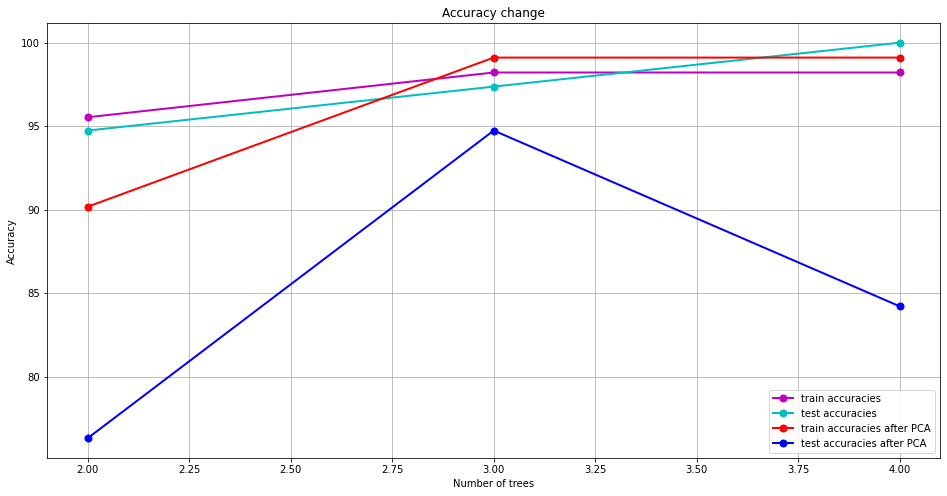

In [157]:
# Визуализируем изменение точности алгоритма
plt.figure(figsize= (16, 8))

plt.plot([2, 3, 4], train_accuracies, 'm-o', linewidth=2, markersize=7,  label = 'train accuracies' )
plt.plot([2, 3, 4], test_accuracies, 'c-o', linewidth=2, markersize=7,  label = 'test accuracies' )
plt.plot([2, 3, 4], train_accuracies_PCA, 'r-o', linewidth=2, markersize=7,  label = 'train accuracies after PCA' )
plt.plot([2, 3, 4], test_accuracies_PCA, 'b-o', linewidth=2, markersize=7,  label = 'test accuracies after PCA' )
    
plt.title('Accuracy change')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')

Построим на двух графиках, чтобы было лучше видно

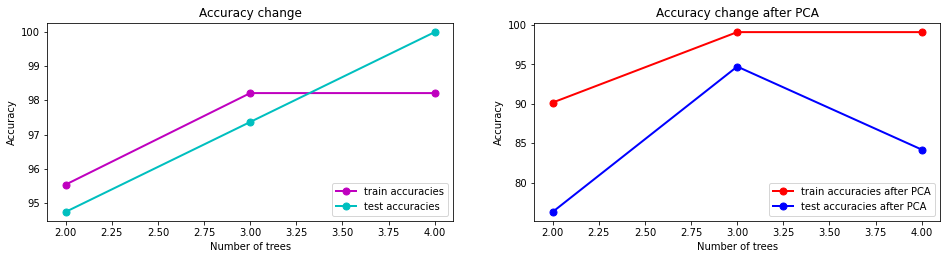

In [159]:
plt.figure(figsize= (16, 8))
plt.xlim(0, 4)

ax1 = plt.subplot(221)  
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
ax1.set_title('Accuracy change')
ax1.plot([2, 3, 4], train_accuracies, 'm-o', linewidth=2, markersize=7,  label = 'train accuracies' )
ax1.plot([2, 3, 4], test_accuracies, 'c-o', linewidth=2, markersize=7,  label = 'test accuracies' )
plt.legend(loc='lower right')

ax2 = plt.subplot(222)
ax2.set_title('Accuracy change after PCA')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.plot([2, 3, 4], train_accuracies_PCA, 'r-o', linewidth=2, markersize=7,  label = 'train accuracies after PCA' )
plt.plot([2, 3, 4], test_accuracies_PCA, 'b-o', linewidth=2, markersize=7,  label = 'test accuracies after PCA' )
plt.legend(loc='lower right')

plt.show()

**Выводы**

Все-таки работа с данными после PCA в "Случайном лесе" дает результат хуже чем, без снижения размерности. После 3х деревьев (на 4х) начинается переобучение. 